# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.33 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [19]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

# Building up the network model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        "*** YOUR CODE HERE ***"
        
        # linear layers
        self.fc1 = nn.Linear(state_size,64)
        self.fc2 = nn.Linear(64,256)  
        self.fc3 = nn.Linear(256,32)
        
        self.fc4 = nn.Linear(32,action_size)
        
        # activation functions
        self.relu = nn.ReLU(inplace=True)
        self.softmax = nn.Softmax()
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        
        x = self.fc1(state)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        
        return x

# agent 

In [7]:
import numpy as np
import random
from collections import namedtuple, deque

# from model import QNetwork

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 5e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 10       # how often to update the network
Exp_A, Exp_B = 0.5, 0.001  # the exponiential parmaters

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.Exp_B = Exp_B

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA, 'train', state, action, reward, next_state)
                
        delta = self.learn(None, GAMMA, 'eval', state, action, reward, next_state)
        
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, delta, done)
                
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
                    
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma, mode, state, action, reward, next_state):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        if mode == 'train':
            states, actions, rewards, next_states, Ps, dones = experiences

            ## TODO: compute and minimize the loss
            "*** YOUR CODE HERE ***"
            ys = rewards + gamma * self.qnetwork_target(next_states).max(dim=1, keepdim=True)[0]
            qs = self.qnetwork_local(states).gather(dim=1, index=actions)

            # train the local network
            self.optimizer.zero_grad()
            self.Exp_B = self.Exp_B**0.995
            loss = torch.div((ys-qs)**2,(Ps*BATCH_SIZE)**self.Exp_B)
            loss = torch.mean(loss)
            loss.backward()
            self.optimizer.step()

            # ------------------- update target network ------------------- #
            self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)  
            
        else:
            action = torch.from_numpy(np.array([[action]])).long().to(device)
            state = torch.from_numpy(np.expand_dims(state, axis = 0)).float().to(device)
            next_state = torch.from_numpy(np.expand_dims(next_state, axis = 0)).float().to(device)
            yd = reward + gamma * self.qnetwork_target(next_state).max(dim=1, keepdim=True)[0]
            qd = self.qnetwork_local(state).gather(dim=1, index=action)
            delta = torch.abs(yd - qd)+1e-5
            return delta.cpu().detach().numpy()[0,0]
    
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)




# memory buffer

In [8]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "delta", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, delta, done):
        """Add a new experience to memory."""
        
        e = self.experience(state, action, reward, next_state, delta, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        Ps = np.power([self.memory[i].delta for i in range(len(self.memory))], Exp_A)
        Ps = Ps/Ps.sum()
        
        experiences = random.choices(self.memory, weights=Ps, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        Ps = torch.from_numpy(np.vstack([e.delta for e in experiences if experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, Ps, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

# Double DQN

In [9]:
def dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
"""


    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    agent = Agent(state_size, action_size, seed=0)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment          
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if (i_episode-1) % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            
    return scores

In [10]:
obtained_score = dqn()

Episode 1	Average Score: 1.00
Episode 11	Average Score: -0.27
Episode 21	Average Score: -0.29
Episode 31	Average Score: -0.13
Episode 41	Average Score: 0.103
Episode 51	Average Score: 0.16
Episode 61	Average Score: 0.15
Episode 71	Average Score: 0.39
Episode 81	Average Score: 0.54
Episode 91	Average Score: 0.68
Episode 101	Average Score: 0.78
Episode 111	Average Score: 1.10
Episode 121	Average Score: 1.50
Episode 131	Average Score: 1.85
Episode 141	Average Score: 2.14
Episode 151	Average Score: 2.54
Episode 161	Average Score: 2.86
Episode 171	Average Score: 3.01
Episode 181	Average Score: 3.31
Episode 191	Average Score: 3.53
Episode 201	Average Score: 3.70
Episode 211	Average Score: 3.76
Episode 221	Average Score: 3.80
Episode 231	Average Score: 3.96
Episode 241	Average Score: 4.21
Episode 251	Average Score: 4.33
Episode 261	Average Score: 4.46
Episode 271	Average Score: 4.87
Episode 281	Average Score: 4.78
Episode 291	Average Score: 5.19
Episode 301	Average Score: 5.47
Episode 311	Ave

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# corresponding y axis values
data = np.array([1,1.00,\
11,-0.27,\
21,-0.29,\
31,-0.13,\
41,0.103,\
51,0.16,\
61,0.15,\
71,0.39,\
81,0.54,\
91,0.68,\
101,0.78,\
111,1.10,\
121,1.50,\
131,1.85,\
141,2.14,\
151,2.54,\
161,2.86,\
171,3.01,\
181,3.31,\
191,3.53,\
201,3.70,\
211,3.76,\
221,3.80,\
231,3.96,\
241,4.21,\
251,4.33,\
261,4.46,\
271,4.87,\
281,4.78,\
291,5.19,\
301,5.47,\
311,5.56,\
321,5.72,\
331,5.83,\
341,5.81,\
351,5.87,\
361,6.06,\
371,6.12,\
381,6.50,\
391,6.60,\
401,6.74,\
411,6.99,\
421,7.55,\
431,7.67,\
441,8.07,\
451,8.35,\
461,8.88,\
471,9.08,\
481,9.38,\
491,9.64,\
501,9.96,\
511,10.58,\
521,10.61,\
531,10.97,\
541,11.30,\
551,11.51,\
561,11.84,\
571,12.03,\
581,12.38,\
591,12.40,\
601,12.68,\
611,12.51,\
621,12.81,\
630,13.04,\
631,13.09,\
632,13.22,\
633,13.30,\
634,13.32,\
635,13.30,\
636,13.34,\
637,13.40,\
638,13.40,\
639,13.33,\
640,13.24,\
641,13.26,\
642,13.27,\
643,13.37,\
644,13.50,\
645,13.47,\
646,13.50,\
647,13.61,\
648,13.46,\
649,13.56,\
650,13.55,\
651,13.48,\
652,13.50,\
653,13.48,\
654,13.53,\
655,13.50,\
656,13.36,\
657,13.35,\
658,13.33,\
659,13.29,\
660,13.33,\
661,13.38,\
662,13.43,\
663,13.54,\
664,13.48,\
665,13.49,\
666,13.54,\
667,13.59,\
668,13.63,\
669,13.63,\
670,13.76,\
671,13.85,\
672,13.85,\
673,13.85,\
674,13.78,\
675,13.67,\
676,13.54,\
677,13.42,\
678,13.28,\
679,13.19,\
680,13.18,\
681,13.20,\
682,13.20,\
683,13.17,\
684,13.16,\
685,13.24,\
686,13.25,\
687,13.27,\
688,13.30,\
689,13.29,\
690,13.40,\
691,13.43,\
692,13.39,\
693,13.34,\
694,13.22,\
695,13.21,\
696,13.24,\
697,13.35,\
698,13.31,\
699,13.36,\
700,13.49,\
701,13.43,\
702,13.57,\
703,13.65,\
704,13.68,\
705,13.73,\
706,13.80,\
707,13.76,\
708,13.86,\
709,13.85,\
710,13.85,\
711,13.88,\
712,13.75,\
713,13.86,\
714,13.78,\
715,13.78,\
716,13.77,\
717,13.75,\
718,13.74,\
719,13.73,\
720,13.86,\
721,13.89,\
722,13.98,\
723,13.91,\
724,13.98,\
725,13.98,\
726,13.99,\
727,14.03,\
728,14.13,\
729,14.16,\
730,14.23,\
731,14.21,\
732,14.05,\
733,14.07,\
734,14.00,\
735,14.04,\
736,13.98,\
737,14.04,\
738,14.00,\
739,14.03,\
740,14.15,\
741,14.16,\
742,14.24,\
743,14.21,\
744,14.20,\
745,14.24,\
746,14.25,\
747,14.29,\
748,14.45,\
749,14.42,\
750,14.36,\
751,14.48,\
752,14.50,\
753,14.57,\
754,14.60,\
755,14.62,\
756,14.61,\
757,14.65,\
758,14.63,\
759,14.68,\
760,14.55,\
761,14.41,\
762,14.34,\
763,14.25,\
764,14.28,\
765,14.12,\
766,14.09,\
767,14.05,\
768,14.12,\
769,14.26,\
770,14.21,\
771,14.22,\
772,14.25,\
773,14.23,\
774,14.40,\
775,14.49,\
776,14.56,\
777,14.76,\
778,14.92,\
779,15.09,\
780,15.19,\
781,15.18,\
782,15.06,\
783,14.97,\
784,15.02,\
785,15.00,\
786,15.00,\
787,14.98,\
788,14.87,\
789,14.75,\
790,14.62,\
791,14.63,\
792,14.63,\
793,14.74,\
794,14.91,\
795,14.95,\
796,14.87,\
797,14.93,\
798,14.91,\
799,14.86,\
800,14.80,\
801,14.85,\
802,14.80,\
803,14.81,\
804,14.84,\
805,14.84,\
806,14.89,\
807,14.91,\
808,14.90,\
809,14.95,\
810,15.00,\
811,15.07,\
812,15.14,\
813,15.05,\
814,15.11,\
815,15.18,\
816,15.24,\
817,15.27,\
818,15.27,\
819,15.32,\
820,15.33,\
821,15.36,\
822,15.28,\
823,15.30,\
824,15.29,\
825,15.31,\
826,15.27,\
827,15.29,\
828,15.20,\
829,15.18,\
830,15.07,\
831,15.04,\
832,15.16,\
833,15.13,\
834,15.16,\
835,15.11,\
836,15.15,\
837,15.11,\
838,15.15,\
839,15.07,\
840,15.06,\
841,15.02,\
842,15.06,\
843,15.02,\
844,14.88,\
845,14.81,\
846,14.74,\
847,14.75,\
848,14.68,\
849,14.70,\
850,14.66,\
851,14.60,\
852,14.63,\
853,14.61,\
854,14.51,\
855,14.50,\
856,14.58,\
857,14.57,\
858,14.55,\
859,14.50,\
860,14.61,\
861,14.68,\
862,14.72,\
863,14.76,\
864,14.84,\
865,15.04,\
866,15.06,\
867,15.08,\
868,15.05,\
869,14.99,\
870,14.97,\
871,14.86,\
872,14.83,\
873,14.82,\
874,14.80,\
875,14.80,\
876,14.87,\
877,14.77,\
878,14.81,\
879,14.77,\
880,14.73,\
881,14.72,\
882,14.69,\
883,14.75,\
884,14.77,\
885,14.81,\
886,14.86,\
887,14.94,\
888,15.09,\
889,15.17,\
890,15.25,\
891,15.26,\
892,15.26,\
893,15.22,\
894,15.18,\
895,15.11,\
896,15.18,\
897,15.18,\
898,15.20,\
899,15.20,\
900,15.27,\
901,15.28,\
902,15.28,\
903,15.28,\
904,15.23,\
905,15.16,\
906,15.10,\
907,15.13,\
908,15.09,\
909,15.13,\
910,15.12,\
911,15.06,\
912,15.02,\
913,15.02,\
914,15.06,\
915,14.95,\
916,14.84,\
917,14.83,\
918,14.91,\
919,14.92,\
920,14.86,\
921,14.85,\
922,14.91,\
923,14.94,\
924,14.94,\
925,14.87,\
926,14.87,\
927,14.83,\
928,14.91,\
929,14.89,\
930,14.95,\
931,15.00,\
932,14.97,\
933,14.96,\
934,15.03,\
935,14.99,\
936,15.01,\
937,14.98,\
938,14.89,\
939,15.01,\
940,15.01,\
941,14.96,\
942,14.96,\
943,15.01,\
944,15.16,\
945,15.22,\
946,15.29,\
947,15.23,\
948,15.32,\
949,15.36,\
950,15.49,\
951,15.52,\
952,15.51,\
953,15.52,\
954,15.64,\
955,15.71,\
956,15.77,\
957,15.79,\
958,15.84,\
959,15.90,\
960,15.87,\
961,15.94,\
962,15.90,\
963,15.95,\
964,15.92,\
965,15.87,\
966,15.81,\
967,15.67,\
968,15.60,\
969,15.48,\
970,15.37,\
971,15.43,\
972,15.36,\
973,15.31,\
974,15.30,\
975,15.29,\
976,15.33,\
977,15.46,\
978,15.40,\
979,15.40,\
980,15.34,\
981,15.33,\
982,15.44,\
983,15.45,\
984,15.37,\
985,15.39,\
986,15.40,\
987,15.37,\
988,15.38,\
989,15.52,\
990,15.55,\
991,15.49,\
992,15.56,\
993,15.52,\
994,15.51,\
995,15.51,\
996,15.45,\
997,15.43,\
998,15.40,\
999,15.48,\
1000,15.44]).reshape([-1,2]).transpose()

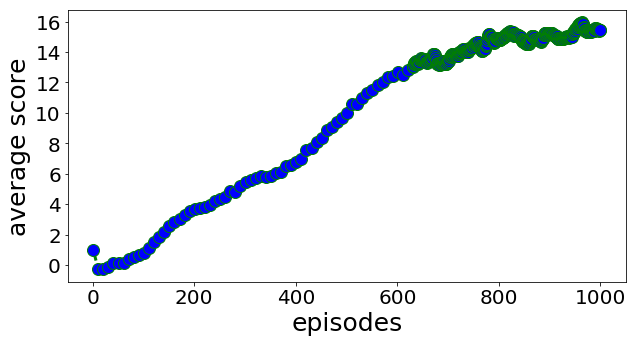

In [54]:
plt.figure(figsize=(10,5))

# plotting the points
plt.plot(data[0], data[1], color='green', linestyle='dashed', linewidth = 3,
		marker='o', markerfacecolor='blue', markersize=12)


# naming the x axis
plt.xlabel('episodes', fontsize = 25)
# naming the y axis
plt.ylabel('average score', fontsize = 25)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# function to show the plot
plt.show()

